# Pets Semantic Segmentation
## <font color=navy>Results
* Based on comparing the optimizer loss trajectory, selected **RMSProp** optimized U-Net CNN and **Adam** optimized U-Net CNN with Attention to compare
* Base final selection off of Precision, Recall, F1-Score, IoU, and human evaluation

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/CPE608\ Final\ Project

/content/drive/MyDrive/CPE608 Final Project


In [ ]:
#### Load data files
# Training/Testing/Validation files
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')[:, :, :, 0]
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')[:, :, :, 0]
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')[:, :, :, 0]

# U-Net CNN Results
unet_rms_train = np.load('data/preds/unet_rmsprop_train.npy')
unet_rms_val = np.load('data/preds/unet_rmsprop_val.npy')
unet_rms_test = np.load('data/preds/unet_rmsprop_test.npy')

# U-Net CNN + Attention Results
att_adam_train = np.load('data/preds/att_adam_train.npy')
att_adam_val = np.load('data/preds/att_adam_val.npy')
att_adam_test = np.load('data/preds/att_adam_test.npy')

## Evaluation Functions

In [ ]:
''' Intersection over Union '''
def iou(true, pred):
  # Get interesction
  intersection = np.logical_and(true, pred)
  union = np.logical_or(true, pred)

  # Return IoU
  return np.sum(intersection) / np.sum(union)

In [ ]:
''' Plot true vs. pred masks with image '''
def plot_masks(img, true, unet_pred, att_pred):
  fig, axs = plt.subplots(1, 4, figsize=(14, 14))

  # Plot image
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[0].set_axis_off()


  # Plot true mask
  axs[1].imshow(true)
  axs[1].set_title('True Mask')
  axs[1].set_axis_off()
  

  # Plot predicted masks
  axs[2].imshow(unet_pred)
  axs[2].set_title('U-Net CNN')
  axs[2].set_axis_off()

  axs[3].imshow(att_pred)
  axs[3].set_title('U-Net CNN with Attention')
  axs[3].set_axis_off()

  return

### U-Net CNN

In [ ]:
# Classification report
print('VALIDATION')
print(classification_report(y_val.flatten(), unet_rms_val.flatten()))
print('IoU: ', iou(y_val.flatten(), unet_rms_val.flatten()))

print()
print('TESTING')
print(classification_report(y_test.flatten(), unet_rms_test.flatten()))
print('IoU: ', iou(y_test.flatten(), unet_rms_test.flatten()))

VALIDATION
              precision    recall  f1-score   support

           1       0.80      0.89      0.84   5542180
           2       0.94      0.89      0.91  11232621
           3       0.56      0.58      0.57   2117999

    accuracy                           0.85  18892800
   macro avg       0.77      0.78      0.77  18892800
weighted avg       0.86      0.85      0.85  18892800

IoU:  1.0

TESTING
              precision    recall  f1-score   support

           1       0.81      0.88      0.85   5654599
           2       0.93      0.89      0.91  11060346
           3       0.57      0.57      0.57   2177855

    accuracy                           0.85  18892800
   macro avg       0.77      0.78      0.78  18892800
weighted avg       0.86      0.85      0.85  18892800

IoU:  1.0


### U-Net CNN with Attention

In [ ]:
# Classification report
print('VALIDATION')
print(classification_report(y_val.flatten(), att_adam_val.flatten()))
print('IoU: ', iou(y_val.flatten(), att_adam_val.flatten()))

print()
print('TESTING')
print(classification_report(y_test.flatten(), att_adam_test.flatten()))
print('IoU: ', iou(y_test.flatten(), att_adam_test.flatten()))

VALIDATION
              precision    recall  f1-score   support

           1       0.80      0.84      0.82   5542180
           2       0.90      0.91      0.91  11232621
           3       0.55      0.44      0.49   2117999

    accuracy                           0.84  18892800
   macro avg       0.75      0.73      0.74  18892800
weighted avg       0.83      0.84      0.84  18892800

IoU:  1.0

TESTING
              precision    recall  f1-score   support

           1       0.81      0.85      0.83   5654599
           2       0.90      0.91      0.91  11060346
           3       0.56      0.44      0.49   2177855

    accuracy                           0.84  18892800
   macro avg       0.75      0.73      0.74  18892800
weighted avg       0.83      0.84      0.83  18892800

IoU:  1.0


### Dataset Examples

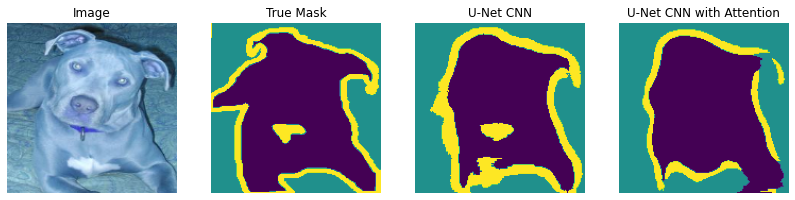

In [ ]:
# Plot training example
plot_masks(X_train[200], y_train[200], unet_rms_train[200], att_adam_train[200])

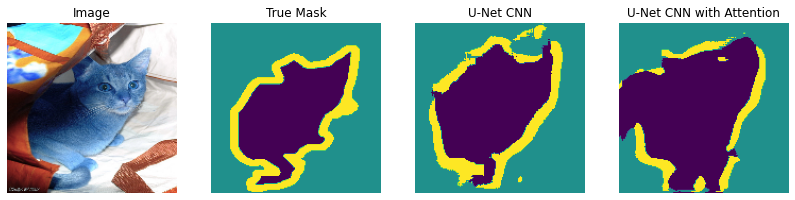

In [ ]:
# Plot validation example
plot_masks(X_val[500], y_val[500], unet_rms_val[500], att_adam_val[500])

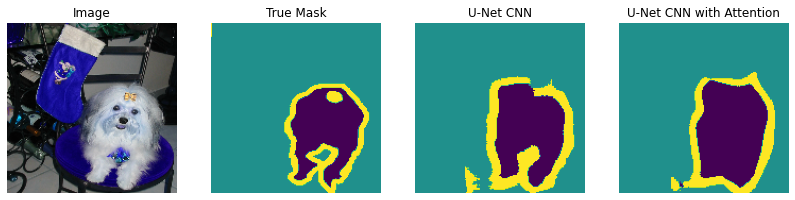

In [ ]:
# Plot testing example
plot_masks(X_test[200], y_test[200], unet_rms_test[200], att_adam_test[200])

### Real Examples

In [ ]:
#### Load models
unet_cnn = load_model('models/cnn_rmsprop.h5')
unet_cnn_att = load_model('models/cnn_attention_adam.h5')

In [ ]:
''' Predict mask '''
def get_mask(img, model):
  # Resize image into a 'batch' to fit classifier
  x = np.zeros((1,) + (160, 160) + (3,), dtype = 'float32')
  img_r = cv2.resize(img, (160, 160))
  x[0] = img_r

  # Get predictions
  pred = model.predict(x)

  # Adjust predictions
  pred = np.argmax(pred[0], axis=-1) + 1

  # Create copy for adjusted mask
  mask = pred.copy()

  # Markers 0 and 1 specify pet; 2 is background
  # - map 0 and 1 together
  mask[mask == 1] = 0
  
  # Mask output is in range [0:1]; scale to [0:255]
  mask = pred.astype('float64')
  mask = mask * 255  + 1  # Scale by 255
  mask = mask.astype('uint8')

  # Mask is now a binary image; resize to original frame size
  mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

  return pred, mask

In [ ]:
# Blur image background (using Gaussian filter)
def blur_background(img, mask):
  # Create a blurred copy of image - use large kernel and sigma so not smoothing effect
  blurred = cv2.GaussianBlur(img, (25, 25), 300)

  # Stack mask into three-channels
  mask = np.stack((mask,)*3, axis=-1)

  # Replace background pixels with blurred pixels
  camera_out = np.where(mask == 255, blurred, img)

  return camera_out

In [ ]:
''' Blur image to keep only pet pixels '''
def blur_img(img, model):
  # Get prediction array and mask
  pred, mask = get_mask(img, model)

  # Blur background
  blur = blur_background(img, mask)

  return blur, mask, pred

In [ ]:
''' Plot image with predicted mask and blurred image '''
def img_mask_blur(img, model):
  fig, axs = plt.subplots(1, 3, figsize=(8, 8))

  # Get mask and blur
  blur, mask, pred = blur_img(img, model)

  # Convert colors for better visuals
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  blur = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

  # Plot image
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[0].set_axis_off()


  # Plot mask
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  axs[1].set_axis_off()
  

  # Plot blurred image
  axs[2].imshow(blur)
  axs[2].set_title('Blurred Image')
  axs[2].set_axis_off()

  return

In [ ]:
# Load testing images
test_1 = cv2.imread('data/test_images/test_1.JPG')
test_2 = cv2.imread('data/test_images/test_2.JPG')
test_3 = cv2.imread('data/test_images/test_3.JPG')

UNet CNN


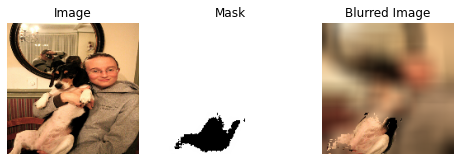

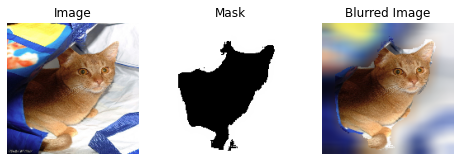

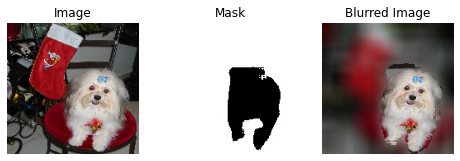

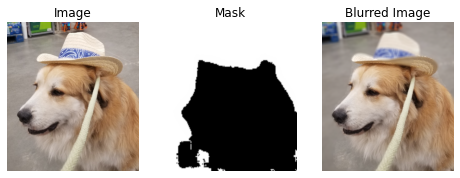

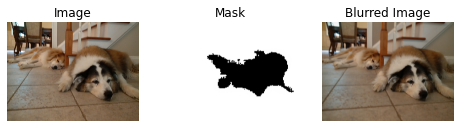

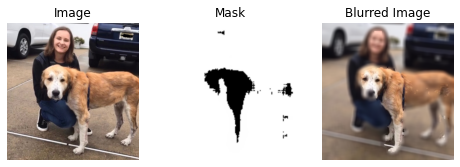

In [ ]:
# Show testing results
print('UNet CNN')
img_mask_blur(X_train[500], unet_cnn)
img_mask_blur(X_val[500], unet_cnn)
img_mask_blur(X_test[200], unet_cnn)
img_mask_blur(test_1, unet_cnn)
img_mask_blur(test_2, unet_cnn)
img_mask_blur(test_3, unet_cnn)

UNet CNN with Attention


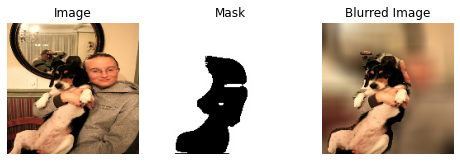

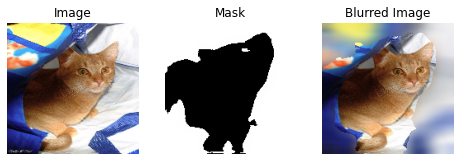

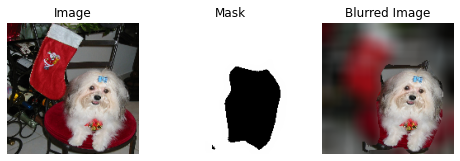

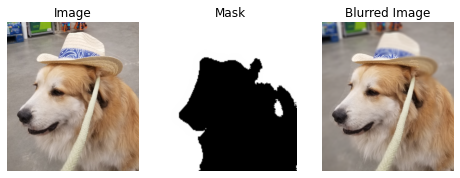

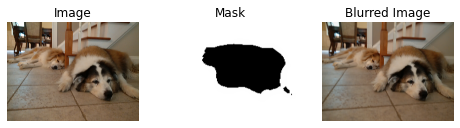

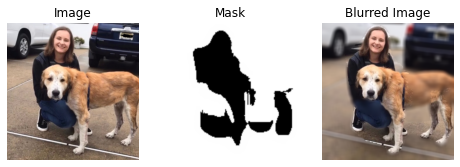

In [ ]:
print('UNet CNN with Attention')
img_mask_blur(X_train[500], unet_cnn_att)
img_mask_blur(X_val[500], unet_cnn_att)
img_mask_blur(X_test[200], unet_cnn_att)
img_mask_blur(test_1, unet_cnn_att)
img_mask_blur(test_2, unet_cnn_att)
img_mask_blur(test_3, unet_cnn_att)